### Approach 1: Deep Neural Net 

#### Import necessary dependencies, raw data from Kaggle dataset in project root directory

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import os
import matplotlib.pyplot as plt
import itertools
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
np.random.seed(2)

In [3]:
data = pd.read_csv('creditcard.csv')


In [4]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


###### Normalize spend amounts,  remove irrelevant columns, split data into test and train set

In [5]:
scaler = StandardScaler()
data['NormalizedAmount'] = scaler.fit_transform(data['Amount'].values.reshape(-1,1))

In [6]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,NormalizedAmount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160686
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.140534
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073403


In [7]:
data = data.drop(['Amount', 'Time'], axis = 'columns')  # drop the regular amount and time cols

In [8]:
y = data['Class']  # holds the class label for each transaction 
X = data.drop(['Class'], axis = 1)  # holds all other features of transaction except class label

In [9]:
# Sklearn's one-liner to split our data into a test set and train set w/ random_seed for reproducibility 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [11]:
train_identity = X_train.index
test_identity = X_test.index

In [12]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

#### Use Keras to create DNN model

In [27]:
model = Sequential()

# units is dimensionality of output space 
# our input is initially made of 31 cols but we've removed 2 so 29 
# after first layer, we no longer need to specify input dim 
model.add(Dense(input_dim = 29, units = 18, activation = 'relu'))
model.add(Dense(units = 24, activation = 'relu'))

model.add(Dropout(0.5))

model.add(Dense(units = 24, activation = 'relu'))
model.add(Dense(units = 24, activation = 'relu'))

model.add(Dense(units = 1, activation = 'sigmoid'))

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 18)                540       
                                                                 
 dense_16 (Dense)            (None, 24)                456       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_17 (Dense)            (None, 24)                600       
                                                                 
 dense_18 (Dense)            (None, 24)                600       
                                                                 
 dense_19 (Dense)            (None, 1)                 25        
                                                                 
Total params: 2,221
Trainable params: 2,221
Non-traina

In [29]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 15, epochs = 5)

Epoch 1/5
13291/13291 [==============================] - 30s 2ms/step - loss: 0.0080 - accuracy: 0.9988 0s -
Epoch 2/5
13291/13291 [==============================] - 30s 2ms/step - loss: 0.0041 - accuracy: 0.9993
Epoch 3/5
13291/13291 [==============================] - 30s 2ms/step - loss: 0.0037 - accuracy: 0.9994
Epoch 4/5
13291/13291 [==============================] - 32s 2ms/step - loss: 0.0034 - accuracy: 0.9994
Epoch 5/5
13291/13291 [==============================] - 33s 2ms/step - loss: 0.0033 - accuracy: 0.9994


#### Now test model performance - note use of confusion matrix since dataset highly imbalanced

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [30]:
predicted_y = model.predict(X_test)

In [31]:
matrix = confusion_matrix(y_test, predicted_y.round())

In [22]:
print(matrix)

[[85279    17]
 [   48    99]]


Confusion matrix, without normalization


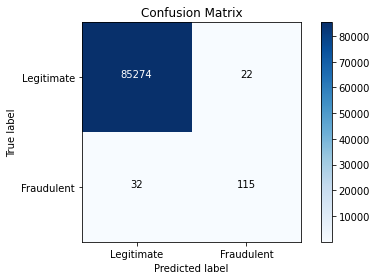

In [34]:
plot_confusion_matrix(matrix, classes = ['Legitimate', 'Fraudulent'])

##### Note that precision score most applicable for CC fraud, but we include F1 score as a common standard metric as well

In [33]:
print(f1_score(y_test, predicted_y.round()))

0.8098591549295774


In [35]:
print(precision_score(y_test, predicted_y.round()))

0.8394160583941606
